## Deep Car: Car Make & Model Detection

In [4]:
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import LambdaLR
from torch.autograd import Variable, Function
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tr
from torchvision import models
from torch.nn import functional as F

from matplotlib import pyplot as plt
from PIL import Image
import os, random, math
%matplotlib inline
from tqdm import tqdm as tqdm

from lab_utils import show_image

import numpy as np
from scipy.io import loadmat

In [5]:
image_root = '../download/data/image'

info_to_idx = {}; idx_to_info = []; cnt = 0

for mk in os.listdir(image_root):
    for md in os.listdir(os.path.join(image_root, mk)):
        num = 0
        for y in os.listdir(os.path.join(image_root, mk, md)):
            num += len(os.listdir(os.path.join(image_root, mk, md, y)))
        if num < 125: continue
        try: tup = (int(mk), int(md))
        except: continue
        if tup not in info_to_idx:
            idx_to_info.append(tup); info_to_idx[tup] = cnt; cnt += 1

In [6]:
"""
@Parameters:
"root_dir": root directory of the dataset
"crop": whether each input image is cropped by the given bounding box
"shuffle": whether the dataset is shuffled after created
"set_split": if true, generates a file of how to split training and testing data,
             otherwise, use an existing file named "split.txt" to split the data
"test_ratio": if "set_split" is true, the splitted (# train data) : (# test data) 
              would be close to "test_ratio" : 1

@Returns: (image, label)
"image": a 3D tensor of size 3x224x224, representing the input image
"label": a list of format: [make, model, year, view_angle, 
                            bbox_left, bbox_upper, bbox_right, bbox_lower]
"""
class CompCars(Dataset):
    def __init__(self, root_dir, preprocess, crop=False, shuffle=False, train=True, set_split=True, test_ratio=1):
        super(CompCars, self).__init__()
        self.data_list = []
        #self.preprocess = tr.Compose([tr.Scale((224, 224)), tr.ToTensor()])
        image_root = os.path.join(root_dir, 'image')
        def process_crop(img, l):
            cropped_img = img.crop(tuple(l))
            w, h = cropped_img.size
            if w == 0 or h == 0: return preprocess(img)
            return preprocess(cropped_img)
                
        if crop:
            self.process = process_crop
        else:
            self.process = lambda img, l: preprocess(img)
        
        if not set_split and 'split.txt' not in os.listdir(root_dir):
            raise ValueError('No split criterion found, but set_split is False')
        if set_split:
            split_f = open(os.path.join(root_dir, 'split.txt'), 'w')
        else:
            split_f = open(os.path.join(root_dir, 'split.txt'), 'r')
        
        for mk in os.listdir(image_root):
            for md in os.listdir(os.path.join(image_root, mk)):
                num = 0
                for y in os.listdir(os.path.join(image_root, mk, md)):
                    num += len(os.listdir(os.path.join(image_root, mk, md, y)))
                if num < 125: continue
        
                for y in os.listdir(os.path.join(image_root, mk, md)):
                    names = os.listdir(os.path.join(image_root, mk, md, y))
                    if set_split:
                        cnt = len(names) / (test_ratio+1)
                        tests = []
                        if cnt == 0: tests = [-1]
                        else: tests = random.sample(xrange(len(names)), cnt)
                        split_f.write(' '.join([str(x) for x in tests]) + '\n')
                    else:
                        teststr = split_f.readline().strip().split(' ')
                        tests = [int(x) for x in teststr]

                    for i, img_name in enumerate(names):
                        if train and i in tests: continue
                        if not train and i not in tests: continue
                        data = self._get_data(root_dir, mk, md, y, img_name)
                        if data is not None: self.data_list.append(data)
                        
        split_f.close()
        if shuffle: random.shuffle(self.data_list)
                      
    def _get_data(self, root_dir, mk, md, y, img_name):
        ret = [None] * 9
        image_file = os.path.join(root_dir, 'image', mk, md, y, img_name)
        label_name = img_name.replace('.jpg', '.txt')
        label_file = os.path.join(root_dir, 'label', mk, md, y, label_name)

        try:
            ret[:4] = [os.path.abspath(image_file), int(mk), int(md), int(y)]
            with open(label_file, 'r') as f:
                for i, l in enumerate(f):
                    if i == 0: ret[4] = int(l.strip())
                    if i == 2: 
                        ret[5:] = [int(x)-1 for x in l.strip().split(' ')]
            return ret
        except:
            return None

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        data = self.data_list[idx]
        with Image.open(data[0]) as img:
            return self.process(img, data[5:]), info_to_idx[tuple(data[1:3])]

In [7]:
train_preprocess = tr.Compose([tr.Resize((256)),
                            tr.RandomHorizontalFlip(), 
                            tr.RandomCrop(224),
                            tr.ColorJitter(
                                brightness=0.5,
                                contrast=0.4,
                                saturation=0.4,
                                hue=0.1
                            ),
                            tr.ToTensor(),
                            tr.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                       ])
val_preprocess = tr.Compose([tr.Resize((256)),
                            tr.CenterCrop(224), 
                            tr.ToTensor(),
                            tr.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                       ])
print 'building training set'
trainset = CompCars('../download/data', train_preprocess, crop=False, train=True, set_split=False, test_ratio=15)
print 'building validation set'
valset = CompCars('../download/data', val_preprocess, crop=False, train=False, set_split=False)

print len(trainset), len(valset), len(idx_to_info)

trainLoader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=16)
valLoader = DataLoader(valset, batch_size=64, shuffle=True, num_workers=16)

building training set
building validation set
16970 776 115


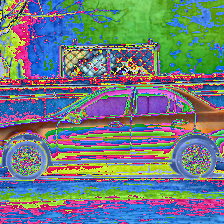

Image predicted as Dongnan, V3 Lingyue with confidence 6.68


In [12]:
make_model_name = loadmat('../download/data/misc/make_model_name.mat')

make_dict = {}
model_dict = {}

id = 1
for make in make_model_name['make_names']:
    make_dict[id] = make[0][0]
    id += 1

id = 1
for model in make_model_name['model_names']:
    if model[0]:
        model_dict[id] = model[0][0]
    id += 1

network = torch.load('fine_tune/epoch200.pt').cpu()
network.eval()




/home/ubuntu/download/data/image/81/108/2012/fcf1e29b9a0da2.jpg
Image predicted as BWM, BWM Z4 with confidence 0.99


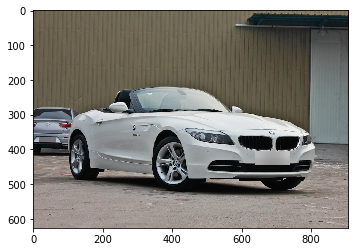

In [31]:
img, _ = valset[100]
act_imgpath = valset.data_list[100][0]
print(act_imgpath)
with Image.open(act_imgpath) as f:
    plt.imshow(f)
predictions = F.softmax(network(Variable(img.unsqueeze(0))))
predictions = predictions.data
max_score, max_label = predictions.max(1)
mk, md = idx_to_info[max_label[0]]
# print mk, md
# show_image(img)
print('Image predicted as %s, %s with confidence %.2f' % (make_dict[mk], model_dict[md], max_score[0]))

In [5]:
# vgg16 = models.vgg16(pretrained = True)
# for param in vgg16.parameters():
#     param.requires_grad = False
# vgg16.classifier = nn.Sequential(
#     nn.Linear(25088, 4096), 
#     nn.ReLU(), 
#     nn.Dropout(0.5),
#     nn.Linear(4096, 4096),
#     nn.ReLU(), 
#     nn.Dropout(0.5),
#     nn.Linear(4096, len(idx_to_info))
# )

# # model = models.resnet18(pretrained=True)
# # for param in model.parameters():
# #     param.requires_grad = False
# # model.fc = nn.Linear(512, len(idx_to_info))
# # optimizer = optim.SGD(model.fc.parameters(), lr = 0.0001)

# optimizer = optim.SGD(vgg16.classifier.parameters(), lr = 0.001)
# # optimizer = optim.Adam(vgg16.classifier.parameters())
# scheduler = LambdaLR(optimizer, lambda e: 1 if e < 10/2 else 0.1)

# criterion = nn.CrossEntropyLoss()

# print 'loaded models'

In [6]:
def train_model(network, criterion, optimizer, scheduler, trainLoader, valLoader, n_epochs = 10):
    network = network.cuda()
    criterion = criterion.cuda()
        
    train_loss_arr = [None] * n_epochs
    train_accuracy_arr = [None] * n_epochs
    valid_loss_arr = [None] * n_epochs
    valid_accuracy_arr = [None] * n_epochs
        
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        for (i, (inputs, labels)) in enumerate(t):
            
            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            inputs = inputs.cuda()
            labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.topk(5, dim=1)
            for j in xrange(5):
                correct += (max_labels[:,j] == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
                                
            train_loss_arr[epoch] = cum_loss / (1 + i)
            train_accuracy_arr[epoch] = 100*correct / counter
        
        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        counter = 0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            inputs = inputs.cuda()
            labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.topk(5, dim=1)
            for j in xrange(5):
                correct += (max_labels[:,j] == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
                    
            valid_loss_arr[epoch] = cum_loss / (1 + i)
            valid_accuracy_arr[epoch] = 100 * correct / counter
        
        scheduler.step()
    
    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('loss scores')
#     axes = plt.gca()
#     axes.set_ylim([1.7,2.0])
    plt.plot(xrange(n_epochs), train_loss_arr)
    plt.plot(xrange(n_epochs), valid_loss_arr)

    plt.savefig('loss.png')

    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('accuracy scores')
#     axes = plt.gca()
#     axes.set_ylim([0.25,0.45])
    plt.plot(xrange(n_epochs), train_accuracy_arr)
    plt.plot(xrange(n_epochs), valid_accuracy_arr)

    plt.savefig('acc.png')

# train_model(vgg16, criterion, optimizer, scheduler, trainLoader, valLoader, n_epochs = 5)

In [32]:
class AttentionCropFunction(Function):
#     @staticmethod
    def forward(ctx, apn_out, inputs):
        h = lambda x: 1 / (1 + torch.exp(-10 * x))
        unit = torch.stack([torch.arange(0, 224)] * 224)
        x = torch.stack([unit.t()] * 3)
        y = torch.stack([unit] * 3)
        if isinstance(inputs, torch.cuda.FloatTensor):
            x, y = x.cuda(), y.cuda()
        
        ret = []
        for i in xrange(inputs.size(0)):
            tx = 112 + int(apn_out[i][0] * 56 + 0.5)
            ty = 112 + int(apn_out[i][1] * 56 + 0.5)
            tl = 28 + int(apn_out[i][2] * 28 + 0.5)
            
            mk = (h(x-tx+tl) - h(x-tx-tl)) * (h(y-ty+tl) - h(y-ty-tl))
            xatt = inputs[i] * mk
            
            xatt_cropped = xatt[:, tx-tl : tx+tl, ty-tl : ty+tl]
            before_upsample = Variable(xatt_cropped.unsqueeze(0))
            xamp = F.upsample(before_upsample, size=(224,224), mode='bilinear')
            ret.append(xamp.data.squeeze())
        
        ret_tensor = torch.stack(ret)
        ctx.save_for_backward(inputs, ret_tensor)
        return ret_tensor
        
#     @staticmethod
    def backward(ctx, grad_output):
        inputs, ret_tensor = ctx.saved_variables[0], ctx.saved_variables[1]
        ret = torch.Tensor(grad_output.size(0), 3).zero_()
        norm = -(grad_output * grad_output).sum(dim=1)
        
#         show_image(inputs.cpu().data[0])
#         show_image(ret_tensor.cpu().data[0])
#         plt.imshow(norm[0].cpu().numpy(), cmap='gray')
        
        x = torch.stack([torch.arange(0, 224)] * 224).t()
        y = x.t()
        mx = (x >= 168).float() - (x < 56).float()
        my = (y >= 168).float() - (y < 56).float()
        ml = (((x<56)+(x>=168)+(y<56)+(y>=168)) > 0).float()*2 - 1
        
        mx_batch = torch.stack([mx.float()] * grad_output.size(0))
        my_batch = torch.stack([my.float()] * grad_output.size(0))
        ml_batch = torch.stack([ml.float()] * grad_output.size(0))
        
        if isinstance(grad_output, torch.cuda.FloatTensor):
            mx_batch = mx_batch.cuda()
            my_batch = my_batch.cuda()
            ml_batch = ml_batch.cuda()
            ret = ret.cuda()
        
        ret[:, 0] = (norm * mx_batch).sum(dim=1).sum(dim=1)
        ret[:, 1] = (norm * my_batch).sum(dim=1).sum(dim=1)
        ret[:, 2] = (norm * ml_batch).sum(dim=1).sum(dim=1)
#         print ret[0]
#         print 1/0
        
        return ret, None

class AttentionCrop(nn.Module):
    def forward(self, apn_out, inputs):
#         return AttentionCropFunction.apply(apn_out, inputs)
        return AttentionCropFunction()(apn_out, inputs)

# class AttentionCrop(nn.Module):
#     def __init__(self):
#         super(AttentionCrop, self).__init__()
#         unit = torch.stack([torch.arange(0, 224)] * 224)
#         self.xx = Variable(torch.stack([unit.t()] * 3))
#         self.yy = Variable(torch.stack([unit] * 3))
        
#         self.h = lambda x: 1 / (1 + torch.exp(-10 * x))
#         self.upsampler = nn.Upsample(size=(224, 224), mode='bilinear')
    
#     def cuda(self):
#         super(AttentionCrop, self).cuda()
#         self.xx = self.xx.cuda()
#         self.yy = self.yy.cuda()
#         return self
    
#     def cpu(self):
#         super(AttentionCrop, self).cpu()
#         self.xx = self.xx.cpu()
#         self.yy = self.yy.cpu()
#         return self
        
#     def forward(self, txtytl, inputs):
#         ret = []
#         for i in xrange(inputs.size(0)):
#             tx = 112 + int(txtytl[i][0].data[0] * 56 + 0.5)
#             ty = 112 + int(txtytl[i][1].data[0] * 56 + 0.5)
#             tl = 28 + int(txtytl[i][2].data[0] * 28 + 0.5)
#             mk = (self.h(self.xx - tx + tl) - self.h(self.xx - tx - tl)) \
#                 *(self.h(self.yy - ty + tl) - self.h(self.yy - ty - tl))
#             xatt = inputs[i] * mk
#             xatt_cropped = xatt[:, tx-tl : tx+tl, ty-tl : ty+tl]
#             xamp = self.upsampler(xatt_cropped.unsqueeze(0)).squeeze()
#             ret.append(xamp)
            
#         return torch.stack(ret)
    
#     def backward(self, grad_output):
#         print 'called'
#         b = grad_output.clone()
#         return Variable(b.data[:, 0, 0, :3].zero_()).cuda(), None 

In [33]:
class RA_CNN(nn.Module):
    def __init__(self):
        super(RA_CNN, self).__init__()
        self.cnn = models.vgg16(pretrained=True).features
        for param in self.cnn.parameters():
            param.requires_grad = False
            
        self.classifier1 = nn.Sequential(
            nn.Linear(25088, 4096), 
            nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(4096, len(idx_to_info))
        )
        self.classifier2 = nn.Sequential(
            nn.Linear(25088, 4096), 
            nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(4096, len(idx_to_info))
        )
        self.apn = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 3),
            nn.Tanh()
        )
        self.cropper = AttentionCrop()
    
    def forward(self, inputs):
        after_cnn1 = self.cnn(inputs).view(inputs.size(0), -1)
        apn_out = self.apn(after_cnn1)
        p1 = self.classifier1(after_cnn1)
        xamp_tensor = self.cropper(apn_out, inputs)
        after_cnn2 = self.cnn(xamp_tensor).view(inputs.size(0), -1)
        p2 = self.classifier2(after_cnn2)
        return p1, p2

In [35]:
def high_response_region(network, inputs):
#     cnn = network.cnn
#     features = cnn(inputs).view(inputs.size[0], 512, 7, 7)
#     square_norm = (features * features).sum(dim = 1)
    
#     for 
    unit = torch.Tensor([0, 0, 1])
    return torch.stack([unit] * inputs.size(0))

def pretrain_apn(network, criterion, optimizer, scheduler, trainLoader, valLoader, n_epochs=10):
    network = network.cuda()
    criterion = criterion.cuda()
    
    for epoch in xrange(n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()
        
        for (i, (inputs, labels)) in enumerate(t):
            inputs = Variable(inputs).cuda()
            features = network.cnn(inputs).view(inputs.size(0), -1)
            outputs = network.apn(features)
            
            expected = high_response_region(network, inputs)
            expected = Variable(expected).cuda()
            
            loss = criterion(outputs, expected)
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()
            
            cum_loss += loss.data[0]
            for j in xrange(outputs.size(0)):
                correct += 1 if int(outputs[j][0].data[0] * 56 + 0.5) == 0 else 0
                correct += 1 if int(outputs[j][1].data[0] * 56 + 0.5) == 0 else 0
                correct += 1 if int(outputs[j][2].data[0] * 28 + 0.5) == 28 else 0
            counter += inputs.size(0) * 3
            t.set_postfix(loss = cum_loss / (1+i), accuracy = 100 * correct / counter)
        
        scheduler.step()
            
# network = RA_CNN()
# criterion = nn.L1Loss()
# optimizer = optim.SGD(network.apn.parameters(), lr = 0.01)
# scheduler = LambdaLR(optimizer, lambda e: 1 if e < 2 else 0.1)

# pretrain_apn(network, criterion, optimizer, scheduler, trainLoader, valLoader, n_epochs=6)
# with open('apn.pt', 'wb') as f:
#     torch.save(network.apn, f)

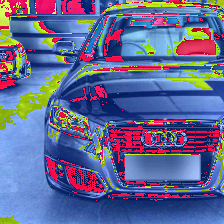

In [36]:
train_preprocess = tr.Compose([
    tr.Resize((256)),
    tr.RandomHorizontalFlip(), 
    tr.RandomCrop(224),
    tr.ColorJitter(
        brightness=0.5,
        contrast=0.4,
        saturation=0.4,
        hue=0.1
    ),
    tr.ToTensor(),
    tr.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

# network = RA_CNN().cuda()
                               
with Image.open('test.jpg') as f:
    ff = Variable(train_preprocess(f).unsqueeze(0)).cuda()
    show_image(ff.cpu().data.squeeze())

# batch = torch.stack([ff] * 4)
# out1, out2 = network(Variable(batch).cuda())
# print out1.size(), out2.size()

In [37]:
def alternative_train(network, c_entropy1, c_entropy2, c_ranking, oc1, oc2, oa, trainLoader, valLoader, n_epochs=10):
    network = network.cuda()
    c_entropy1 = c_entropy1.cuda()
    c_entropy2 = c_entropy2.cuda()
    c_ranking = c_ranking.cuda()
    
    for epoch in xrange(n_epochs):
        correct1 = correct2 = 0.0
        cum_loss1 = cum_loss2 = 0.0
        counter = 0
        t = tqdm(trainLoader, desc = 'Classifier epoch %d' % epoch)
        network.train()
        for step in range(30): 
            for (i, (inputs, labels)) in enumerate(t):
                inputs = Variable(inputs).cuda()
                labels = Variable(labels).cuda()
                outputs1, outputs2 = network(inputs)

                loss1 = c_entropy1(outputs1, labels)
                oc1.zero_grad()
                loss1.backward()
                oc1.step()

                loss2 = c_entropy2(outputs2, labels)
                oc2.zero_grad()
                loss2.backward()
                oc2.step()

                counter += inputs.size(0)
                cum_loss1 += loss1.data[0]
                max_scores, max_labels = outputs1.data.topk(5, dim=1)
                for j in xrange(5):
                    correct1 += (max_labels[:,j] == labels.data).sum()

                cum_loss2 += loss2.data[0]
                max_scores, max_labels = outputs2.data.topk(5, dim=1)
                for j in xrange(5):
                    correct2 += (max_labels[:,j] == labels.data).sum()

                t.set_postfix(loss1 = cum_loss1 / (1+i), acc1 = 100 * correct1 / counter,
                              loss2 = cum_loss2 / (1+i), acc2 = 100 * correct2 / counter)

        cum_loss = 0
        t = tqdm(trainLoader, desc = 'Attention epoch %d, step %d' % (epoch, step))
        
        for (i, (inputs, labels)) in enumerate(t):
            if i % 20 == 0:
                features = network.cnn(ff).view(-1)
                txtytl = network.apn(features)
                print txtytl
            inputs = Variable(inputs).cuda()
            labels = Variable(labels).cuda()
            outputs1, outputs2 = network(inputs)
            
            p1 = torch.Tensor(outputs1.size(1))._zero()
            p2 = torch.Tensor(outputs2.size(1))._zero()
            for cnt, idx in enumerate(labels.data):
                p1[cnt] = outputs1.data[cnt,idx]
                p2[cnt] = outputs2.data[cnt,idx]
                
            p1 = Variable(p1).cuda()
            p2 = Variable(p2).cuda()
            y = Variable(torch.Tensor(outputs1.size(1)).fill_(-1)).cuda()
            loss = c_ranking(p1, p2, y)
            oa.zero_grad()
            loss.backward()
            oa.step()
            
            cum_loss += loss.data[0]
            t.set_postfix(loss = cum_loss / (1+i))

network = RA_CNN()
network.apn = torch.load('apn.pt')
# converged_network = torch.load("./racnn/racnn81.pt")
# network.classifier1 = converged_network.classifier1
# network.classifier2 = converged_network.classifier2

c_entropy1 = nn.CrossEntropyLoss()
c_entropy2 = nn.CrossEntropyLoss()
c_ranking = nn.MarginRankingLoss(margin=0.05)
oc1 = optim.SGD(network.classifier1.parameters(), lr=0.001)
oc2 = optim.SGD(network.classifier2.parameters(), lr=0.001)
oa = optim.SGD(network.apn.parameters(), lr=1e-6)

alternative_train(network, c_entropy1, c_entropy2, c_ranking, oc1, oc2, oa, trainLoader, valLoader, n_epochs=10)

Classifier epoch 0:  10%|█         | 27/266 [00:17<02:36,  1.53it/s, acc1=3.88, acc2=4.8, loss1=4.78, loss2=4.76] Process Process-6:
Process Process-1:
Process Process-16:
Process Process-11:
Process Process-15:
Process Process-7:
Process Process-8:
Process Process-2:
Process Process-3:
Process Process-9:
Traceback (most recent call last):
Process Process-10:
Process Process-5:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-13:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/torch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/ubuntu/anaconda3/envs/torch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Process Process-12:
Process Process-14:
Process Process-4:
  File "/home/ubuntu/anaconda3/envs/torch/lib/python2.7/multiprocessing/proce

    racquire()
    r = index_queue.get()
    r = index_queue.get()
  File "/home/ubuntu/anaconda3/envs/torch/lib/python2.7/multiprocessing/queues.py", line 374, in get
    racquire()
  File "/home/ubuntu/anaconda3/envs/torch/lib/python2.7/multiprocessing/queues.py", line 374, in get
  File "/home/ubuntu/anaconda3/envs/torch/lib/python2.7/multiprocessing/queues.py", line 374, in get
  File "/home/ubuntu/anaconda3/envs/torch/lib/python2.7/multiprocessing/queues.py", line 374, in get
    r = index_queue.get()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
    racquire()
    racquire()
  File "/home/ubuntu/anaconda3/envs/torch/lib/python2.7/multiprocessing/queues.py", line 374, in get
    racquire()
  File "/home/ubuntu/anaconda3/envs/torch/lib/python2.7/multiprocessing/queues.py", line 374, in get
    racquire()
  File "/home/ubuntu/anaconda3/envs/torch/lib/python2.7/multiprocessing/queues.py", line 374, in get
  File "/home/ubuntu/anaconda3/envs/torch/lib/python2

KeyboardInterrupt: 